In [6]:
import scipy.io
import numpy as np
import sys
import eqdist_grappa_cuda
import torch

device = torch.device("cuda:0")

import sys
sys.path.append(r'D:\GitHub\pymrghost')
import mrfft

brain_data = scipy.io.loadmat("brain_32ch.mat")['DATA']
calib_torch = torch.tensor(mrfft.crop(brain_data, [60,60,brain_data.shape[2]]).astype(np.complex64)).cuda()
block_size = (2, 2)
acc_factors_2d = (2, 3)
regularization_factor = 0.001

brain_data_und = np.zeros_like(brain_data)
brain_data_und[2::acc_factors_2d[0],1::acc_factors_2d[1],:] = brain_data[2::acc_factors_2d[0],1::acc_factors_2d[1],:]

brain_data_und_torch=torch.tensor(brain_data_und.astype(np.complex64))

# Run the GRAPPA weight calibration
grappa_weights_torch = eqdist_grappa_cuda.GRAPPA_calibrate_weights_2d_torch(calib_torch, acc_factors_2d, device, block_size, regularization_factor)

kspace_recon_kykxc, image_coilcombined_sos, unmixing_map_coilWise = eqdist_grappa_cuda.GRAPPA_interpolate_imageSpace_2d_torch(
    brain_data_und_torch, acc_factors_2d, block_size, grappa_weights_torch, device)

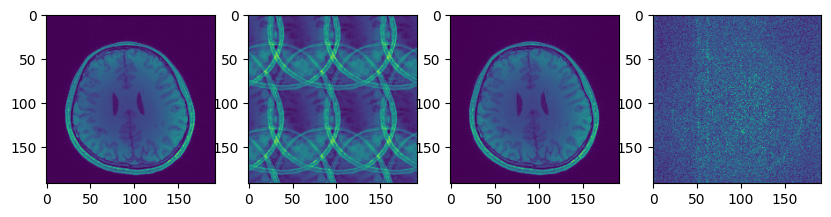

In [7]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10))
plt.subplot(1,4,1)
plt.imshow(mrfft.sos(mrfft.ifft2c(brain_data,axes=(0,1))))
plt.subplot(1,4,2)
plt.imshow(mrfft.sos(mrfft.ifft2c(brain_data_und_torch.cpu().numpy(),axes=(0,1))))
plt.subplot(1,4,3)
plt.imshow(mrfft.sos(mrfft.ifft2c(kspace_recon_kykxc.cpu().numpy(),axes=(0,1))))
plt.subplot(1,4,4)
plt.imshow(mrfft.sos(mrfft.ifft2c(brain_data-kspace_recon_kykxc.cpu().numpy(),axes=(0,1))))
plt.show()

In [11]:
%timeit grappa_weights_torch = eqdist_grappa_cuda.GRAPPA_calibrate_weights_2d_torch(calib_torch, acc_factors_2d, device, block_size, regularization_factor)

198 ms ± 255 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [12]:
%timeit kspace_recon_kykxc, image_coilcombined_sos, unmixing_map_coilWise = eqdist_grappa_cuda.GRAPPA_interpolate_imageSpace_2d_torch(brain_data_und_torch, acc_factors_2d, block_size, grappa_weights_torch, device)

13.2 ms ± 3.68 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
